## CODE
#### Imports


In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle
import seg_metrics.seg_metrics as sg
import pandas as pd

#### User Input Data


In [2]:
path_training_dataset = "D:\\Work\\Sarbazi\\data\\all_data\\training"
path_testing_dataset = "D:\\Work\\Sarbazi\\data\\all_data\\testing"
batch_size = 2
femur_locator = False
if femur_locator:
    # for femur locator
    image_shape = (1024//2, 1024//2)
    crop_enabled = False
    naugment = 1
else:
    # for accurate segmentation
    image_shape = (1024//2, 768//2)
    crop_enabled = True
    naugment = 4

#### Data Generation


In [3]:
MyUtils = reload(MyUtils)
training_data = MyUtils.DataGenerator(path_training_dataset, batch_size, image_shape, crop_enabled, naugment, True, True)
testing_data = MyUtils.DataGenerator(path_testing_dataset, batch_size, image_shape, crop_enabled, naugment, False, True)

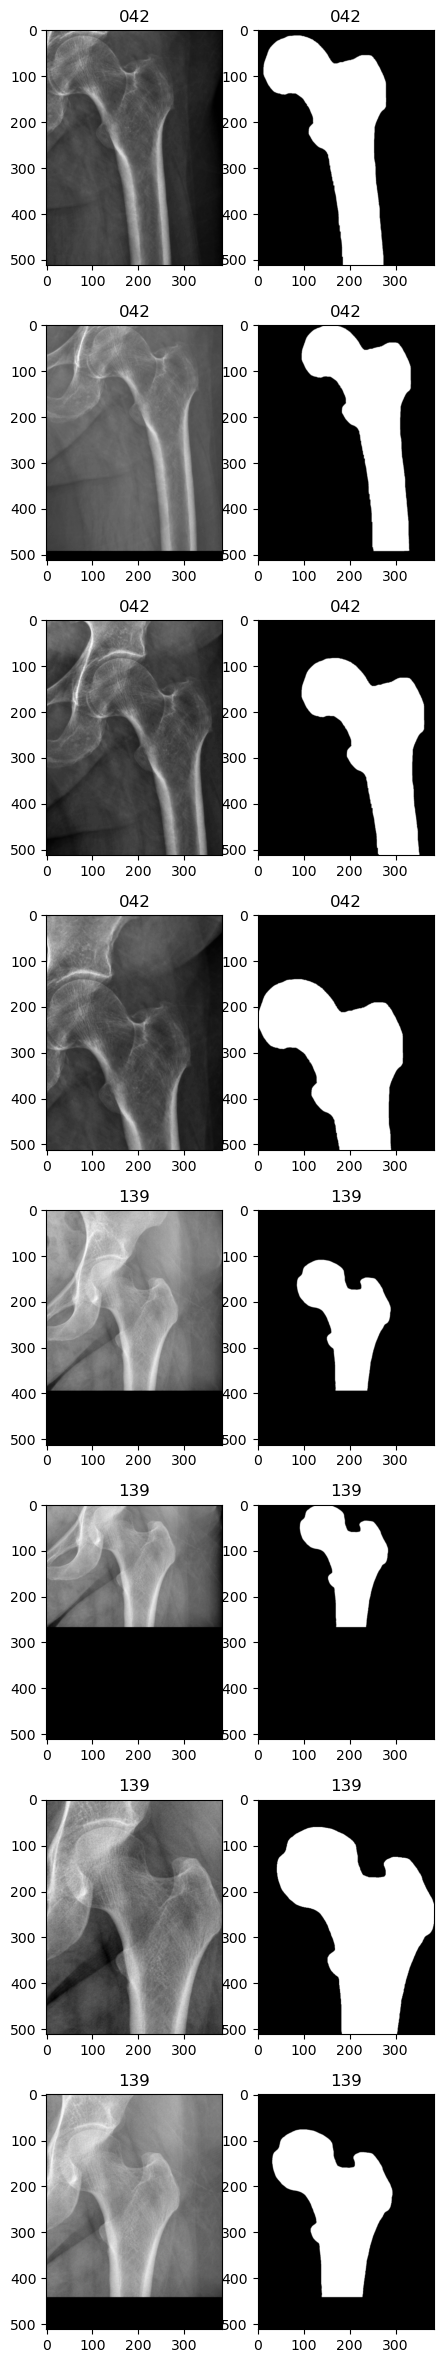

In [4]:
batch_id = 0
sample_batch_image, sample_batch_mask = training_data.__getitem__(batch_id)
img_ids = training_data._get_image_ids(batch_id)
fig, ax = plt.subplots(sample_batch_image.shape[0], 2, figsize=(5, 30))
for i in range(sample_batch_image.shape[0]):
    ax[i, 0].imshow(sample_batch_image[i,:,:,0],cmap='gray')
    ax[i, 0].set_title(str(img_ids[i//naugment]).zfill(3))
    ax[i, 1].imshow(sample_batch_mask[i,:,:,0],cmap='gray')
    ax[i, 1].set_title(str(img_ids[i//naugment]).zfill(3))

#### Create U-Net


In [5]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
if femur_locator:
    UNetModel = UNet.create_UNet_locator((*image_shape,1), (*image_shape,1))
else:
    UNetModel = UNet.create_UNet_accurate((*image_shape,1), (*image_shape,1))
UNetModel.compile(optimizer=MyUtils.keras.optimizers.Adam(), loss=MyUtils.keras.losses.BinaryCrossentropy())
# UNetModel.compile(optimizer=MyUtils.keras.optimizers.Adam(), loss=MyUtils.dice_coef_loss)
# UNetModel.summary(line_length=120)

In [30]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=100, workers=10, verbose=0)

In [31]:
if femur_locator:
    UNetModel.save('UNetModel_locator.h5')
else:
    UNetModel.save('UNetModel_accurate.h5')

In [6]:
if femur_locator:
    UNetModel = UNet.keras_models.load_model('UNetModel_locator.h5')
else:
    UNetModel = UNet.keras_models.load_model('UNetModel_accurate.h5')

In [7]:
batch_id = 0
sample_test_image, sample_test_mask = testing_data.__getitem__(batch_id)
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.bool_)

1/1 [==============================] - 5s 5s/step


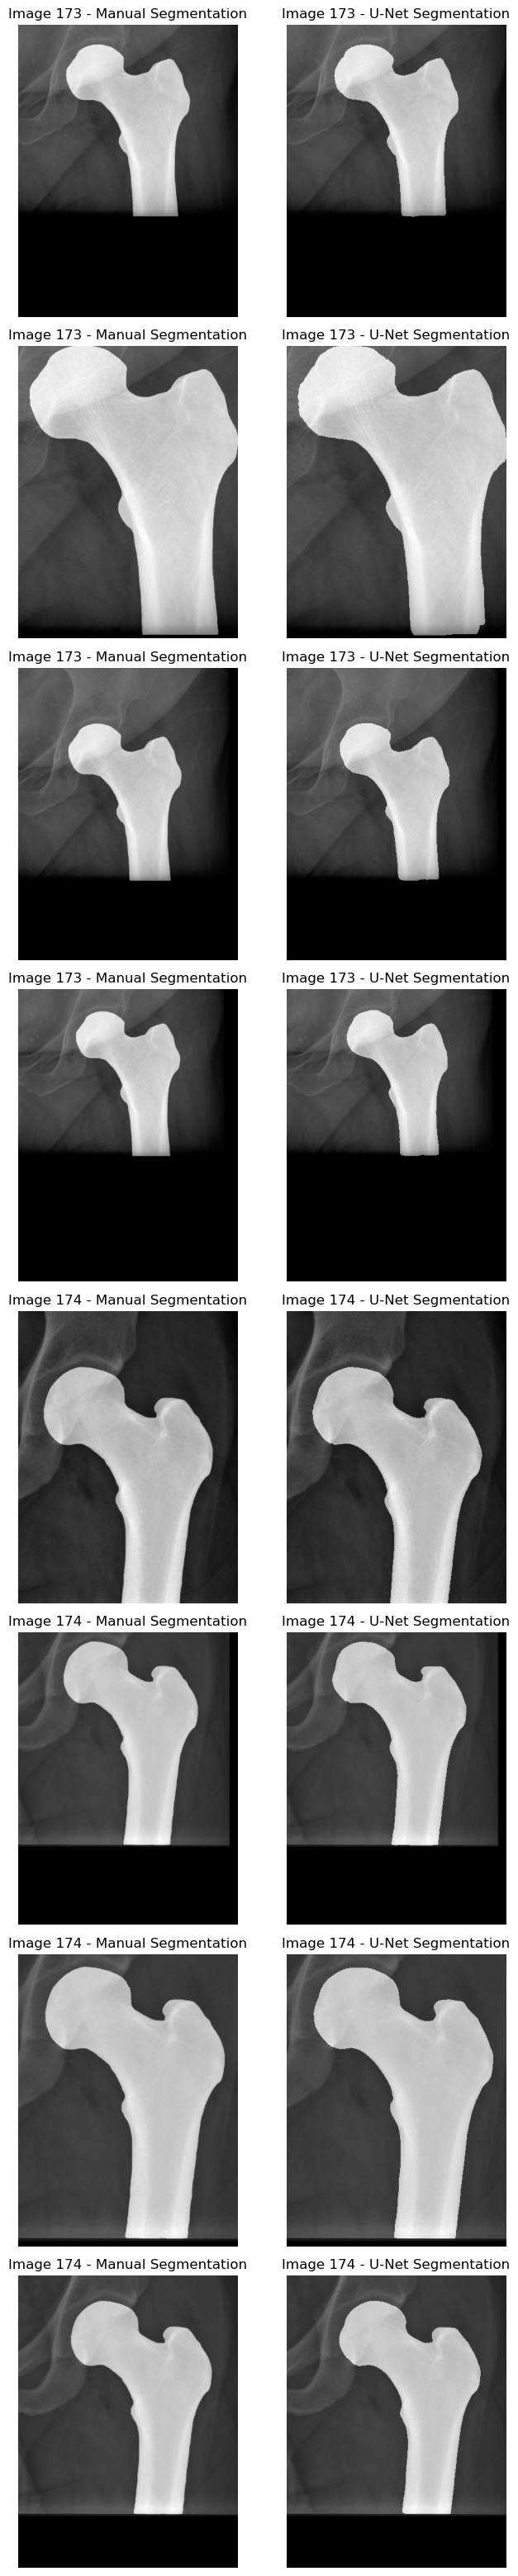

In [8]:
fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(8,40))
titles = [str(i).zfill(3) for i in testing_data._get_image_ids(batch_id)]
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,0].set_title("Image %s - Manual Segmentation" % (titles[i//naugment]))
    axs[i,0].axis('off')
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,1].set_title("Image %s - U-Net Segmentation" % (titles[i//naugment]))
    axs[i,1].axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [9]:
# with open('out.png','wb') as f:
#     fig.savefig(f, dpi=600)

## evaluation on selected dataset


In [22]:
eval_data = testing_data
gdth_img = []
pred_img = []
for i in range(len(eval_data)):
    images, masks = eval_data[i]
    predict_segment = UNetModel.predict(images, verbose=0)
    predict_segment = (predict_segment>0.5).astype(np.int_)
    for m in range(masks.shape[0]):
        gdth_img.append(masks[m,:,:,0])
        pred_img.append(predict_segment[m,:,:,0])
labels = [0, 1]
spacing = [0.3, 0.3]
metrics = sg.write_metrics(labels=labels[1:],  # exclude background if needed
                          gdth_img=gdth_img,
                          pred_img=pred_img,
                          spacing=spacing,
                          TPTNFPFN=True)
reshape_metrics = {} 
for m in metrics:
    for k in m.keys():
        try:
            reshape_metrics[k].append(m[k][0])
        except:
            reshape_metrics[k] = []
            reshape_metrics[k].append(m[k][0])


for k in reshape_metrics.keys():
    reshape_metrics[k] = np.array(reshape_metrics[k])

reshape_metrics["nfpr"] = reshape_metrics["FP"] / (reshape_metrics["TP"]+reshape_metrics["FN"])
n = reshape_metrics["TP"] + reshape_metrics["TN"] + reshape_metrics["FP"] + reshape_metrics["FN"]
fa = reshape_metrics["TP"]+reshape_metrics["TN"]
fc = (reshape_metrics["TN"]+reshape_metrics["FN"])*(reshape_metrics["TN"]+reshape_metrics["FP"]) + (reshape_metrics["FP"]+reshape_metrics["TP"])*(reshape_metrics["FN"]+reshape_metrics["TP"])
fc /= n
reshape_metrics["kap"] = (fa-fc)/(n-fc)
reshape_metrics["auc"] = 1-(reshape_metrics["fpr"]+reshape_metrics["fnr"])/2
reshape_metrics["acc"] = (reshape_metrics["TP"]+reshape_metrics["TN"])/n
reshape_metrics["inf"] = 1-reshape_metrics["fnr"]-reshape_metrics["fpr"]
ppv = reshape_metrics["TP"]/(reshape_metrics["TP"]+reshape_metrics["FP"])
npv = reshape_metrics["TN"]/(reshape_metrics["TN"]+reshape_metrics["FN"])
reshape_metrics["mk"] = ppv + npv - 1
reshape_metrics.pop("label")
reshape_metrics.pop("TP")
reshape_metrics.pop("TN")
reshape_metrics.pop("FP")
reshape_metrics.pop("FN")

168it [00:35,  4.79it/s]


array([   1,  300,  280,  146,   28,   40,   90,   14,  426,    6,   30,
         47, 3127,  153,   26,   30,    0,    0,    0,   79,  528,  385,
        308,  106,  206,   31,   63,  148,  718, 2317,  160,   87,    2,
         14,   32,  248, 6453, 5284,   42,   10,   25,   57,    3,   48,
       3578,   18, 5283,   70,   19,  312,  910,  133,  246,   90,  284,
        369,    6,    0,   10,   22,  312,  220,  205,  524,    0,   11,
          0,    0,    1,   28,   25,    4,    0,    8,   63,   31,  457,
         91,  401,  376,   17,    5,   44,   55,   16,    1,   23,  151,
         70,    0,    1,    0,    2,    0,    4,    3,    6,   14,    5,
          5,    0,    0,    0,    8,    0,    0,  209,    0,   19,   18,
         12,  123,   17,   33,   51,  125,  459,   19,   19,   33,   19,
       1811,  577,  332,    5,   21,    0,   43,   21,    0,    3,    1,
         36,  149,  123,   21,  385,  112,   21,   68,  715,  223,  565,
        816,    1,    3,    5,   13,   19,    4,   

In [23]:
myorder_metrics = {}
for k in ["dice", "jaccard", "acc", "precision", "recall", "fpr", "fnr", "nfpr", "kap", "auc", "inf", "mk", "hd", "msd", "mdsd", "stdsd", "hd95"]:
    myorder_metrics[k] = reshape_metrics[k]
for k in myorder_metrics.keys():
    print("%s" % k)
for k in myorder_metrics.keys():
    print("%.2f \u00B1 %.2f" % (np.round(np.mean(myorder_metrics[k]), decimals=2), np.round(np.std(myorder_metrics[k]), decimals=2)))

dice
jaccard
acc
precision
recall
fpr
fnr
nfpr
kap
auc
inf
mk
hd
msd
mdsd
stdsd
hd95
0.98 ± 0.01
0.96 ± 0.01
0.99 ± 0.00
0.96 ± 0.01
1.00 ± 0.01
0.02 ± 0.00
0.00 ± 0.01
0.04 ± 0.01
0.97 ± 0.01
0.99 ± 0.01
0.98 ± 0.01
0.96 ± 0.01
3.40 ± 4.01
0.61 ± 0.31
0.53 ± 0.10
0.52 ± 0.78
1.60 ± 2.34


In [24]:
df = pd.DataFrame(myorder_metrics)
df.to_csv("accurate_network_metrics.csv")